<a href="https://colab.research.google.com/github/ditumystro/Skin-detection-with-python/blob/main/Skin-detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

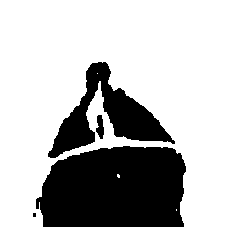

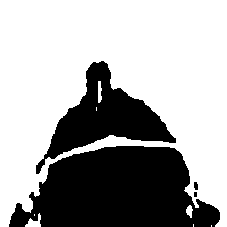

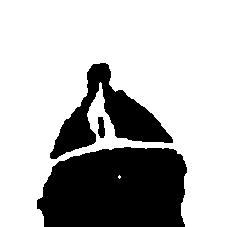

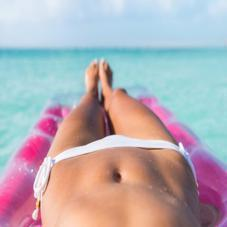

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np

#Open a simple image
img=cv2.imread("0724.jpg")

#converting from gbr to hsv color space
img_HSV = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

#skin color range for hsv color space 
HSV_mask = cv2.inRange(img_HSV, (0, 15, 0), (17,170,255)) 
HSV_mask = cv2.morphologyEx(HSV_mask, cv2.MORPH_OPEN, np.ones((3,3), np.uint8))

#converting from gbr to YCbCr color space
img_YCrCb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
#skin color range for hsv color space 
YCrCb_mask = cv2.inRange(img_YCrCb, (0, 135, 85), (255,180,135)) 
YCrCb_mask = cv2.morphologyEx(YCrCb_mask, cv2.MORPH_OPEN, np.ones((3,3), np.uint8))

#merge skin detection (YCbCr and hsv)
global_mask=cv2.bitwise_and(YCrCb_mask,HSV_mask)
global_mask=cv2.medianBlur(global_mask,3)
global_mask = cv2.morphologyEx(global_mask, cv2.MORPH_OPEN, np.ones((4,4), np.uint8))


HSV_result = cv2.bitwise_not(HSV_mask)
YCrCb_result = cv2.bitwise_not(YCrCb_mask)
global_result=cv2.bitwise_not(global_mask)


#show results
cv2_imshow(HSV_result)
cv2_imshow(YCrCb_result)
cv2_imshow(global_result)
cv2_imshow(img)
cv2.imwrite("1_HSV.jpg",HSV_result)
cv2.imwrite("2_YCbCr.jpg",YCrCb_result)
cv2.imwrite("3_global_result.jpg",global_result)
cv2.waitKey(0)
cv2.destroyAllWindows()  

In [ ]:
MIDDLE_DATA_DIR = '/middle_data'
OBJECTS = ['SKIN','NON_SKIN']

In [ ]:
def train(OBJECTS, EXTENSION=EXT, SAVE_INTERMEDIATE_DATA=False, SHOW=True):
	#Welcome message
	print('-     - ------ -     ----   ---  - _ -  ----   -----  --- ')
	print(' - - -  |-- 	  -    |      |   | |   |  |--      |   |   |')
	print('  - -   -----  ----  ----   ---  -   -  ----     |    --- ')


	
	#Initilization of histograms
	for i in range(0,len(CLASSES)):
		# Filling 0 value to all
		HISTS.append([[0] * 256  for i in range(256)])
	IMAGES_NUMBER = len([name for name in os.listdir(DIR_TRAIN) if os.path.isfile(os.path.join(DIR_TRAIN, name))])
	IMAGES_NUMBER /=len(CLASSES)+1
	IMAGES_NUMBER = int(IMAGES_NUMBER)
	# Looping through images in dataset
	#print(IMAGES_NUMBER)
	print('****************')
	print('STARTED TRAIN :'+strftime("%Y-%m-%d %H:%M:%S", gmtime()))
	print('****************')
	for i in range(0,IMAGES_NUMBER):
		print('Image [',str(i+1),']..................................['+str(i+1)+'/'+str(IMAGES_NUMBER)+']')
		##### Original image
		orig = str(i+1)+EXTENSION
		img_orig = cv2.imread(DIR_TRAIN+'/'+orig)

		##### Conversion to CIELAB space
		#print(img_orig)
		img_orig_lab = cv2.cvtColor((img_orig/SCALE).astype(np.uint8), cv2.COLOR_BGR2LAB)

		##### Filename every class
		fnames = []
		for k in range(0, len(CLASSES)):
			fnames.append(str(i+1)+CLASS_SUFFIXES[k]+EXTENSION)

		##### Mask Images for every class
		masks = []
		for k in range(0, len(CLASSES)):
			masks.append(cv2.imread(DIR_TRAIN+'/'+fnames[k],0))
		
		##### Shape size for loop
		h = img_orig.shape[0]
		w = img_orig.shape[1]

		##### Looping through pixels
		for y in range(0, h-1):
			for x in range(0, w-1):
				# Temporary variables for A&B [We ignore the L]
				tmp_a = img_orig_lab[y,x][1]
				tmp_b = img_orig_lab[y,x][2]

				for k in range(0, len(CLASS_SUFFIXES)):
				# Increment count in HISTS[k] according to mask value
					if(masks[k][y,x] != 0):
						HISTS[k][tmp_a][tmp_b] +=1
						DATA_PIX[k]+=1
				DATA_PIX[2]+=1

		if(SAVE_INTERMEDIATE_DATA):
	  		for o in range(0,len(CLASSES)):
	  			cv2.imwrite(INTERMEDIATE_DATAS_DIR+'/'+str(i)+CLASS_SUFFIXES[o]+'_masked_by_'+CLASSES[o]+EXTENSION, cv2.bitwise_and(img_orig,img_orig,mask = masks[o]))
		  	if(not Path(SAVED_VALUES_DIR).is_dir()):
		  		os.mkdir(SAVED_VALUES_DIR)
		  	if(not Path(SAVED_VALUES_DIR+'/'+CONFIG_SAVED_FILE).is_file()):
		  		os.mknod(SAVED_VALUES_DIR+'/'+CONFIG_SAVED_FILE)
		  	f = open(SAVED_VALUES_DIR+'/'+CONFIG_SAVED_FILE, "wb")
		  	f.truncate(0)
		  	pickler = pickle.Pickler(f)
		  	pickler.dump([HISTS,DATA_PIX])
	print('****************')
	print('FINISHED TRAIN :'+strftime("%Y-%m-%d %H:%M:%S", gmtime()))
	print('****************')
	if True:
		His = []
		##### Histogramm normalization to get values between [0,1]
		for k in range(0,len(HISTS)):
			His.append([array(x) / DATA_PIX[k] for x in HISTS[k]])
		for i in range(0,len(HISTS)):
			histo_file = SAVED_VALUES_DIR+'/'+'HISTOGRAM_NORMALIZED_'+CLASSES[i]+'.csv'
			if(not Path(histo_file).is_file()):
				os.mknod(histo_file)
			with open(histo_file, 'w', newline='') as myfile:
				myfile.truncate(0)
				wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
				wr.writerow(His[i])
			histo_file = SAVED_VALUES_DIR+'/'+'HISTOGRAM_'+CLASSES[i]+'.csv'
			if(not Path(histo_file).is_file()):
				os.mknod(histo_file)
			with open(histo_file, 'w', newline='') as myfile:
				myfile.truncate(0)
				wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
				wr.writerow(HISTS[i])
	f = open(SAVED_VALUES_DIR+'/'+CONFIG_SAVED_FILE, "wb")
	f.truncate(0)
	pickler = pickle.Pickler(f)
	pickler.dump([HISTS,DATA_PIX])
	return HISTS